In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Algorithm: KMeans, n_clusters: 2
Silhouette Score: 0.1395, Davies-Bouldin Index: 2.3995
Algorithm: KMeans, n_clusters: 3
Silhouette Score: 0.1375, Davies-Bouldin Index: 2.0267
Algorithm: KMeans, n_clusters: 4
Silhouette Score: 0.1354, Davies-Bouldin Index: 1.8599
Algorithm: KMeans, n_clusters: 5
Silhouette Score: 0.1334, Davies-Bouldin Index: 1.7378
Algorithm: Agglomerative, n_clusters: 2
Silhouette Score: 0.1103, Davies-Bouldin Index: 2.7437
Algorithm: Agglomerative, n_clusters: 3
Silhouette Score: 0.1033, Davies-Bouldin Index: 2.4942
Algorithm: Agglomerative, n_clusters: 4
Silhouette Score: 0.0821, Davies-Bouldin Index: 2.2995
Algorithm: Agglomerative, n_clusters: 5
Silhouette Score: 0.0637, Davies-Bouldin Index: 2.3515
Algorithm: GMM, n_clusters: 2
Silhouette Score: 0.1359, Davies-Bouldin Index: 2.4480
Algorithm: GMM, n_clusters: 3
Silhouette Score: 0.1297, Davies-Bouldin Index: 2.1654
Algorithm: GMM, n_clusters: 4
Silhouette Score: 0.1237, Davies-Bouldin Index: 2.8502
Algorithm: GM

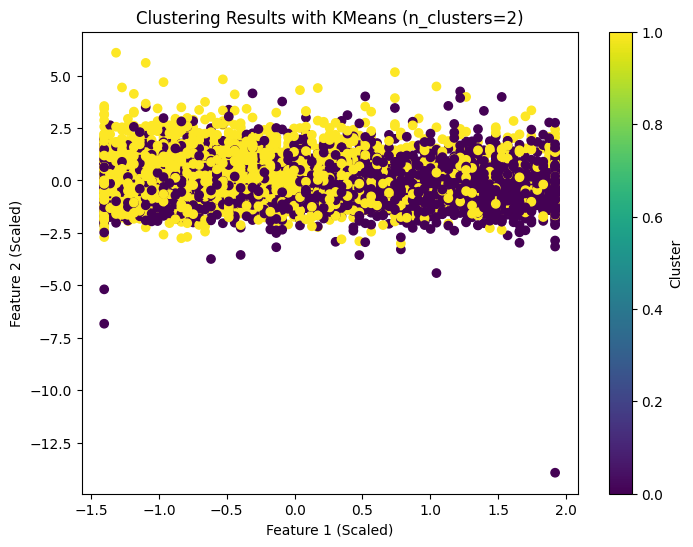

In [10]:
# -*- coding: utf-8 -*-

"""Revised ERP Clustering Script.

This script incorporates several improvements for single-trial ERP analysis
and clustering, including artifact rejection, multi-channel P300 feature
extraction, and more flexible clustering evaluation.
"""

import os
import numpy as np
import scipy.io
from scipy.stats import zscore
from scipy.signal import find_peaks
from sklearn.cluster import KMeans, AgglomerativeClustering, estimate_bandwidth, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Data Loading and Setup
directory_path = '/content/drive/MyDrive/EEG_dataset/splitset'  # Update this path
train_files = [f for f in os.listdir(directory_path) if 'train' in f]
sampling_rate = 256  # Hz
p300_window = (300, 600)  # ms, time window for peak detection
selected_channels = [24, 27, 31]  # Example channels (adjust based on your data)
amplitude_threshold = 100 #threshold in microvolts for artifact rejection

# 2. Helper Functions

def reject_artifact_trial(trial_data, threshold=amplitude_threshold):
    """Rejects a single trial if any channel exceeds the amplitude threshold."""
    return np.all(np.abs(trial_data) < threshold)

def extract_p300_features(trial_data, channel_idx, sampling_rate, p300_window):
    """Extracts P300 latency and amplitude from a single channel."""
    start_sample = int(p300_window[0] / 1000 * sampling_rate)
    end_sample = int(p300_window[1] / 1000 * sampling_rate)
    p300_signal = trial_data[start_sample:end_sample]
    peak_index = np.argmax(p300_signal)
    latency = (peak_index + start_sample) / sampling_rate
    amplitude = p300_signal[peak_index]
    return latency, amplitude

# 3. Feature Extraction and Artifact Rejection
all_features = []

for train_file in train_files:
    file_path = os.path.join(directory_path, train_file)
    eeg_data = scipy.io.loadmat(file_path)['train_data'] #or other name

    num_trials = eeg_data.shape[2]

    for trial_idx in range(num_trials):
        trial_data = eeg_data[:, :, trial_idx] #timepoints x channels

        # # Artifact Rejection
        # if not reject_artifact_trial(trial_data):
        #     continue  # Skip this trial if it contains artifacts

        # Extract P300 features from each selected channel
        trial_features = []
        for channel_idx in selected_channels:
            latency, amplitude = extract_p300_features(trial_data[:, channel_idx-1], channel_idx, sampling_rate, p300_window)
            trial_features.extend([latency, amplitude])

        all_features.append(trial_features)

# 4. Feature Matrix Preparation
feature_matrix = np.array(all_features)

from sklearn.impute import SimpleImputer

# Assuming feature_matrix is your data
if feature_matrix.size == 0:  # Check if the array is empty
    print("Feature matrix is empty.")
else:
    # Reshape if necessary (assuming single feature here)
    if len(feature_matrix.shape) == 1:
        feature_matrix = feature_matrix.reshape(-1, 1)

    imputer = SimpleImputer(strategy='mean')
    feature_matrix_imputed = imputer.fit_transform(feature_matrix)

#Handle Missing values: Impute or Remove
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Or 'median'
feature_matrix = imputer.fit_transform(feature_matrix)

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

# 5. Clustering and Evaluation

def evaluate_clustering(data, labels):
    """Evaluates clustering performance using silhouette score and Davies-Bouldin index."""
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    return silhouette, davies_bouldin

def perform_clustering(data, algorithm='KMeans', n_clusters=3):
    """Performs clustering using the specified algorithm."""
    if algorithm == 'KMeans':
        model = KMeans(n_clusters=n_clusters, n_init = 'auto', random_state=42)
    elif algorithm == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters)
    elif algorithm == 'GMM':
        model = GaussianMixture(n_components=n_clusters, random_state=42)
    elif algorithm == 'MeanShift':
        bandwidth = estimate_bandwidth(data, quantile=0.3)
        model = MeanShift(bandwidth=bandwidth)

    else:
        raise ValueError("Invalid clustering algorithm specified.")

    labels = model.fit_predict(data)
    return labels, model

# Experiment with different algorithms and parameters
clustering_algorithms = ['KMeans', 'Agglomerative', 'GMM']  # Remove 'MeanShift'
n_clusters_range = range(2, 6)  # Explore different numbers of clusters

best_silhouette = -1
best_algorithm = None
best_n_clusters = None
best_labels = None
best_model = None

for algorithm in clustering_algorithms:
    for n_clusters in n_clusters_range:
        try:
            labels, model = perform_clustering(scaled_features, algorithm=algorithm, n_clusters=n_clusters)
            silhouette, davies_bouldin = evaluate_clustering(scaled_features, labels)
            print(f"Algorithm: {algorithm}, n_clusters: {n_clusters}")
            print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {davies_bouldin:.4f}")

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_algorithm = algorithm
                best_n_clusters = n_clusters
                best_labels = labels
                best_model = model
        except Exception as e:
            print(f"Error with {algorithm} and {n_clusters} clusters: {e}")

print("\nBest Clustering Result:")
print(f"Algorithm: {best_algorithm}, n_clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")

# 6. Visualization of Best Clustering Result
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=best_labels, cmap='viridis')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.title(f'Clustering Results with {best_algorithm} (n_clusters={best_n_clusters})')
plt.colorbar(label='Cluster')
plt.show()


Algorithm: KMeans, n_clusters: 2
Silhouette Score: 0.0903, Davies-Bouldin Index: 2.9775
Algorithm: KMeans, n_clusters: 3
Silhouette Score: 0.0764, Davies-Bouldin Index: 2.8152
Algorithm: KMeans, n_clusters: 4
Silhouette Score: 0.0714, Davies-Bouldin Index: 2.7332
Algorithm: KMeans, n_clusters: 5
Silhouette Score: 0.0679, Davies-Bouldin Index: 2.7191
Algorithm: Agglomerative, n_clusters: 2
Silhouette Score: 0.0476, Davies-Bouldin Index: 3.9041
Algorithm: Agglomerative, n_clusters: 3
Silhouette Score: 0.0381, Davies-Bouldin Index: 3.8183
Algorithm: Agglomerative, n_clusters: 4
Silhouette Score: 0.0344, Davies-Bouldin Index: 3.5114
Algorithm: Agglomerative, n_clusters: 5
Silhouette Score: 0.0175, Davies-Bouldin Index: 3.2833
Algorithm: GMM, n_clusters: 2
Silhouette Score: 0.0876, Davies-Bouldin Index: 5.3025
Algorithm: GMM, n_clusters: 3
Silhouette Score: 0.0304, Davies-Bouldin Index: 4.4647
Algorithm: GMM, n_clusters: 4
Silhouette Score: 0.0345, Davies-Bouldin Index: 4.3493
Algorithm: GM

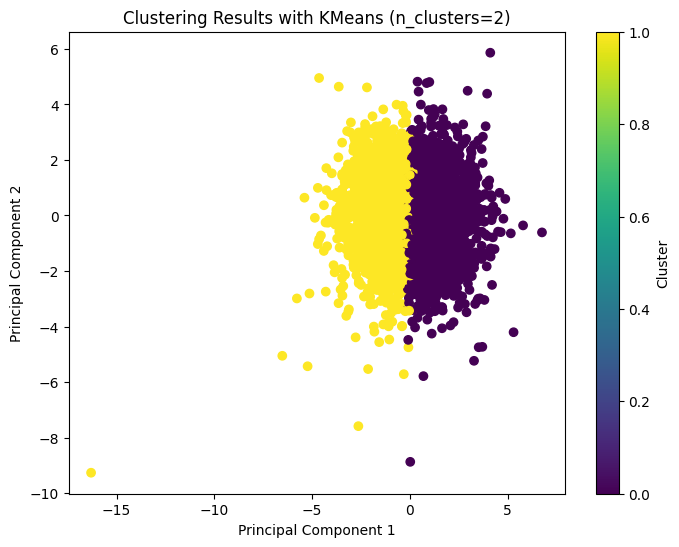


Interpret the clusters based on their characteristics (e.g., average ERP waveforms).
Consider relating the clusters to attention levels or ADHD subtypes.


In [12]:
# -*- coding: utf-8 -*-

"""Revised ERP Clustering Script.

This script incorporates several improvements for single-trial ERP analysis
and clustering, including artifact rejection, multi-channel P300 and N200 feature
extraction, and more flexible clustering evaluation.
"""

import os
import numpy as np
import scipy.io
from scipy.stats import zscore
from scipy.signal import find_peaks
from sklearn.cluster import KMeans, AgglomerativeClustering, estimate_bandwidth, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1. Data Loading and Setup
directory_path = '/content/drive/MyDrive/EEG_dataset/splitset'  # Update this path
train_files = [f for f in os.listdir(directory_path) if 'train' in f]
sampling_rate = 256  # Hz
p300_window = (300, 600)  # ms, time window for peak detection
n200_window = (100, 300)  # ms, time window for N200 peak detection
selected_channels = [24, 27, 31]  # Example channels (adjust based on your data)
amplitude_threshold = 100 #threshold in microvolts for artifact rejection

# 2. Helper Functions

def reject_artifact_trial(trial_data, threshold=amplitude_threshold):
    """Rejects a single trial if any channel exceeds the amplitude threshold."""
    return np.all(np.abs(trial_data) < threshold)

def extract_p300_features(trial_data, channel_idx, sampling_rate, p300_window):
    """Extracts P300 latency and amplitude from a single channel."""
    start_sample = int(p300_window[0] / 1000 * sampling_rate)
    end_sample = int(p300_window[1] / 1000 * sampling_rate)
    p300_signal = trial_data[start_sample:end_sample]
    peak_index = np.argmax(p300_signal)
    latency = (peak_index + start_sample) / sampling_rate
    amplitude = p300_signal[peak_index]
    return latency, amplitude

def extract_n200_features(trial_data, channel_idx, sampling_rate, n200_window):
    """Extracts N200 latency and amplitude from a single channel."""
    start_sample = int(n200_window[0] / 1000 * sampling_rate)
    end_sample = int(n200_window[1] / 1000 * sampling_rate)
    n200_signal = trial_data[start_sample:end_sample]
    peak_index = np.argmin(n200_signal)  # N200 is a negative peak
    latency = (peak_index + start_sample) / sampling_rate
    amplitude = n200_signal[peak_index]
    return latency, amplitude

# 3. Feature Extraction and Artifact Rejection
all_features = []

for train_file in train_files:
    file_path = os.path.join(directory_path, train_file)
    eeg_data = scipy.io.loadmat(file_path)['train_data'] #or other name

    num_trials = eeg_data.shape[2]

    for trial_idx in range(num_trials):
        trial_data = eeg_data[:, :, trial_idx] #timepoints x channels

        # # Artifact Rejection
        # if not reject_artifact_trial(trial_data):
        #     continue  # Skip this trial if it contains artifacts

        # Extract P300 and N200 features from each selected channel
        trial_features = []
        for channel_idx in selected_channels:
            p300_latency, p300_amplitude = extract_p300_features(trial_data[:, channel_idx-1], channel_idx, sampling_rate, p300_window)
            n200_latency, n200_amplitude = extract_n200_features(trial_data[:, channel_idx-1], channel_idx, sampling_rate, n200_window)
            trial_features.extend([p300_latency, p300_amplitude, n200_latency, n200_amplitude])

        all_features.append(trial_features)

# 4. Feature Matrix Preparation
feature_matrix = np.array(all_features)

from sklearn.impute import SimpleImputer

# Assuming feature_matrix is your data
if feature_matrix.size == 0:  # Check if the array is empty
    print("Feature matrix is empty.")
else:
    # Reshape if necessary (assuming single feature here)
    if len(feature_matrix.shape) == 1:
        feature_matrix = feature_matrix.reshape(-1, 1)

    imputer = SimpleImputer(strategy='mean')
    feature_matrix_imputed = imputer.fit_transform(feature_matrix)

#Handle Missing values: Impute or Remove
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Or 'median'
feature_matrix = imputer.fit_transform(feature_matrix)

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

# 5. Clustering and Evaluation

def evaluate_clustering(data, labels):
    """Evaluates clustering performance using silhouette score and Davies-Bouldin index."""
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    return silhouette, davies_bouldin

def perform_clustering(data, algorithm='KMeans', n_clusters=3):
    """Performs clustering using the specified algorithm."""
    if algorithm == 'KMeans':
        model = KMeans(n_clusters=n_clusters, n_init = 'auto', random_state=42)
    elif algorithm == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters)
    elif algorithm == 'GMM':
        model = GaussianMixture(n_components=n_clusters, random_state=42)
    elif algorithm == 'MeanShift':
        bandwidth = estimate_bandwidth(data, quantile=0.3)
        model = MeanShift(bandwidth=bandwidth)

    else:
        raise ValueError("Invalid clustering algorithm specified.")

    labels = model.fit_predict(data)
    return labels, model

# Experiment with different algorithms and parameters
clustering_algorithms = ['KMeans', 'Agglomerative', 'GMM']  # Remove 'MeanShift'
n_clusters_range = range(2, 6)  # Explore different numbers of clusters

best_silhouette = -1
best_algorithm = None
best_n_clusters = None
best_labels = None
best_model = None

for algorithm in clustering_algorithms:
    for n_clusters in n_clusters_range:
        try:
            labels, model = perform_clustering(scaled_features, algorithm=algorithm, n_clusters=n_clusters)
            silhouette, davies_bouldin = evaluate_clustering(scaled_features, labels)
            print(f"Algorithm: {algorithm}, n_clusters: {n_clusters}")
            print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {davies_bouldin:.4f}")

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_algorithm = algorithm
                best_n_clusters = n_clusters
                best_labels = labels
                best_model = model
        except Exception as e:
            print(f"Error with {algorithm} and {n_clusters} clusters: {e}")

print("\nBest Clustering Result:")
print(f"Algorithm: {best_algorithm}, n_clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")

from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Visualization of Best Clustering Result
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=best_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Clustering Results with {best_algorithm} (n_clusters={best_n_clusters})')
plt.colorbar(label='Cluster')
plt.show()

# # 6. Visualization of Best Clustering Result
# plt.figure(figsize=(8, 6))
# plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=best_labels, cmap='viridis')
# plt.xlabel('Feature 1 (Scaled)')
# plt.ylabel('Feature 2 (Scaled)')
# plt.title(f'Clustering Results with {best_algorithm} (n_clusters={best_n_clusters})')
# plt.colorbar(label='Cluster')
# plt.show()

# 7. Interpretation (Placeholder)
print("\nInterpret the clusters based on their characteristics (e.g., average ERP waveforms).")
print("Consider relating the clusters to attention levels or ADHD subtypes.")


Algorithm: KMeans, n_clusters: 2
Silhouette Score: 0.0767, Davies-Bouldin Index: 3.2380
Algorithm: KMeans, n_clusters: 3
Silhouette Score: 0.0619, Davies-Bouldin Index: 3.1258
Algorithm: KMeans, n_clusters: 4
Silhouette Score: 0.0522, Davies-Bouldin Index: 3.2083
Algorithm: KMeans, n_clusters: 5
Silhouette Score: 0.0416, Davies-Bouldin Index: 3.1609
Algorithm: Agglomerative, n_clusters: 2
Silhouette Score: 0.0545, Davies-Bouldin Index: 3.8333
Algorithm: Agglomerative, n_clusters: 3
Silhouette Score: 0.0285, Davies-Bouldin Index: 4.1075
Algorithm: Agglomerative, n_clusters: 4
Silhouette Score: 0.0165, Davies-Bouldin Index: 4.4426
Algorithm: Agglomerative, n_clusters: 5
Silhouette Score: 0.0176, Davies-Bouldin Index: 4.1504
Algorithm: GMM, n_clusters: 2
Silhouette Score: 0.0586, Davies-Bouldin Index: 7.5050
Algorithm: GMM, n_clusters: 3
Silhouette Score: 0.0408, Davies-Bouldin Index: 5.5743
Algorithm: GMM, n_clusters: 4
Silhouette Score: 0.0276, Davies-Bouldin Index: 4.8611
Algorithm: GM

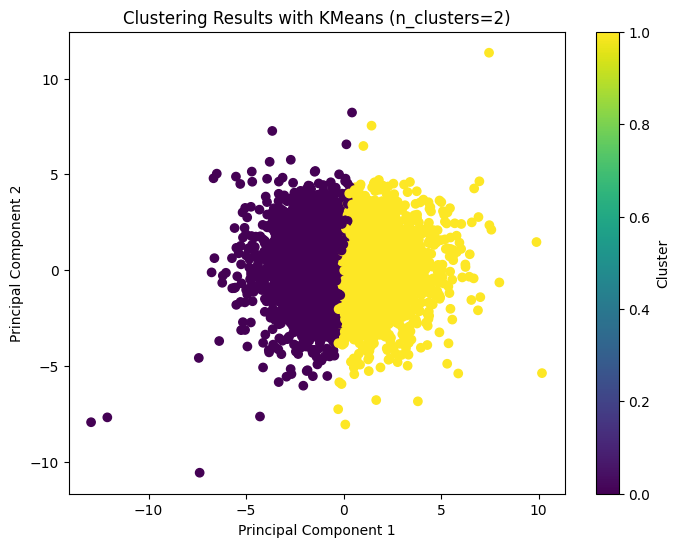


Interpret the clusters based on their characteristics (e.g., average ERP waveforms).
Consider relating the clusters to attention levels or ADHD subtypes.


In [13]:
# -*- coding: utf-8 -*-

"""Revised ERP Clustering Script.

This script incorporates several improvements for single-trial ERP analysis
and clustering, including artifact rejection, multi-channel P300, N1, P1, P2 feature
extraction, and more flexible clustering evaluation.
"""

import os
import numpy as np
import scipy.io
from scipy.stats import zscore
from scipy.signal import find_peaks
from sklearn.cluster import KMeans, AgglomerativeClustering, estimate_bandwidth, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Data Loading and Setup
directory_path = '/content/drive/MyDrive/EEG_dataset/splitset'  # Update this path
train_files = [f for f in os.listdir(directory_path) if 'train' in f]
sampling_rate = 256  # Hz
p300_window = (300, 600)  # ms, time window for peak detection
n1_window = (50, 150)  # ms, time window for N1 peak detection
p1_window = (70, 120)  # ms, time window for P1 peak detection
p2_window = (150, 250)  # ms, time window for P2 peak detection
selected_channels = [24, 27, 31]  # Example channels (adjust based on your data)
amplitude_threshold = 100 #threshold in microvolts for artifact rejection

# 2. Helper Functions

def reject_artifact_trial(trial_data, threshold=amplitude_threshold):
    """Rejects a single trial if any channel exceeds the amplitude threshold."""
    return np.all(np.abs(trial_data) < threshold)

def extract_p300_features(trial_data, channel_idx, sampling_rate, p300_window):
    """Extracts P300 latency and amplitude from a single channel."""
    start_sample = int(p300_window[0] / 1000 * sampling_rate)
    end_sample = int(p300_window[1] / 1000 * sampling_rate)
    p300_signal = trial_data[start_sample:end_sample]
    peak_index = np.argmax(p300_signal)
    latency = (peak_index + start_sample) / sampling_rate
    amplitude = p300_signal[peak_index]
    return latency, amplitude

def extract_n1_features(trial_data, channel_idx, sampling_rate, n1_window):
    """Extracts N1 latency and amplitude from a single channel."""
    start_sample = int(n1_window[0] / 1000 * sampling_rate)
    end_sample = int(n1_window[1] / 1000 * sampling_rate)
    n1_signal = trial_data[start_sample:end_sample]
    peak_index = np.argmin(n1_signal)  # N1 is a negative peak
    latency = (peak_index + start_sample) / sampling_rate
    amplitude = n1_signal[peak_index]
    return latency, amplitude

def extract_p1_features(trial_data, channel_idx, sampling_rate, p1_window):
    """Extracts P1 latency and amplitude from a single channel."""
    start_sample = int(p1_window[0] / 1000 * sampling_rate)
    end_sample = int(p1_window[1] / 1000 * sampling_rate)
    p1_signal = trial_data[start_sample:end_sample]
    peak_index = np.argmax(p1_signal)
    latency = (peak_index + start_sample) / sampling_rate
    amplitude = p1_signal[peak_index]
    return latency, amplitude

def extract_p2_features(trial_data, channel_idx, sampling_rate, p2_window):
    """Extracts P2 latency and amplitude from a single channel."""
    start_sample = int(p2_window[0] / 1000 * sampling_rate)
    end_sample = int(p2_window[1] / 1000 * sampling_rate)
    p2_signal = trial_data[start_sample:end_sample]
    peak_index = np.argmax(p2_signal)
    latency = (peak_index + start_sample) / sampling_rate
    amplitude = p2_signal[peak_index]
    return latency, amplitude

# 3. Feature Extraction and Artifact Rejection
all_features = []

for train_file in train_files:
    file_path = os.path.join(directory_path, train_file)
    eeg_data = scipy.io.loadmat(file_path)['train_data'] #or other name

    num_trials = eeg_data.shape[2]

    for trial_idx in range(num_trials):
        trial_data = eeg_data[:, :, trial_idx] #timepoints x channels

        # # Artifact Rejection
        # if not reject_artifact_trial(trial_data):
        #     continue  # Skip this trial if it contains artifacts

        # Extract ERP features from each selected channel
        trial_features = []
        for channel_idx in selected_channels:
            p300_latency, p300_amplitude = extract_p300_features(trial_data[:, channel_idx-1], channel_idx, sampling_rate, p300_window)
            n1_latency, n1_amplitude = extract_n1_features(trial_data[:, channel_idx-1], channel_idx, sampling_rate, n1_window)
            p1_latency, p1_amplitude = extract_p1_features(trial_data[:, channel_idx-1], channel_idx, sampling_rate, p1_window)
            p2_latency, p2_amplitude = extract_p2_features(trial_data[:, channel_idx-1], channel_idx, sampling_rate, p2_window)
            trial_features.extend([p300_latency, p300_amplitude, n1_latency, n1_amplitude, p1_latency, p1_amplitude, p2_latency, p2_amplitude])

        all_features.append(trial_features)

# 4. Feature Matrix Preparation
feature_matrix = np.array(all_features)

from sklearn.impute import SimpleImputer

# Assuming feature_matrix is your data
if feature_matrix.size == 0:  # Check if the array is empty
    print("Feature matrix is empty.")
else:
    # Reshape if necessary (assuming single feature here)
    if len(feature_matrix.shape) == 1:
        feature_matrix = feature_matrix.reshape(-1, 1)

    imputer = SimpleImputer(strategy='mean')
    feature_matrix_imputed = imputer.fit_transform(feature_matrix)

#Handle Missing values: Impute or Remove
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Or 'median'
feature_matrix = imputer.fit_transform(feature_matrix)

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

# 5. Clustering and Evaluation

def evaluate_clustering(data, labels):
    """Evaluates clustering performance using silhouette score and Davies-Bouldin index."""
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    return silhouette, davies_bouldin

def perform_clustering(data, algorithm='KMeans', n_clusters=3):
    """Performs clustering using the specified algorithm."""
    if algorithm == 'KMeans':
        model = KMeans(n_clusters=n_clusters, n_init = 'auto', random_state=42)
    elif algorithm == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters)
    elif algorithm == 'GMM':
        model = GaussianMixture(n_components=n_clusters, random_state=42)
    elif algorithm == 'MeanShift':
        bandwidth = estimate_bandwidth(data, quantile=0.3)
        model = MeanShift(bandwidth=bandwidth)

    else:
        raise ValueError("Invalid clustering algorithm specified.")

    labels = model.fit_predict(data)
    return labels, model

# Experiment with different algorithms and parameters
clustering_algorithms = ['KMeans', 'Agglomerative', 'GMM']  # Remove 'MeanShift'
n_clusters_range = range(2, 6)  # Explore different numbers of clusters

best_silhouette = -1
best_algorithm = None
best_n_clusters = None
best_labels = None
best_model = None

for algorithm in clustering_algorithms:
    for n_clusters in n_clusters_range:
        try:
            labels, model = perform_clustering(scaled_features, algorithm=algorithm, n_clusters=n_clusters)
            silhouette, davies_bouldin = evaluate_clustering(scaled_features, labels)
            print(f"Algorithm: {algorithm}, n_clusters: {n_clusters}")
            print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {davies_bouldin:.4f}")

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_algorithm = algorithm
                best_n_clusters = n_clusters
                best_labels = labels
                best_model = model
        except Exception as e:
            print(f"Error with {algorithm} and {n_clusters} clusters: {e}")

print("\nBest Clustering Result:")
print(f"Algorithm: {best_algorithm}, n_clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")

# 6. Visualization of Best Clustering Result
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=best_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Clustering Results with {best_algorithm} (n_clusters={best_n_clusters})')
plt.colorbar(label='Cluster')
plt.show()

# 7. Interpretation (Placeholder)
print("\nInterpret the clusters based on their characteristics (e.g., average ERP waveforms).")
print("Consider relating the clusters to attention levels or ADHD subtypes.")


Feature matrix is empty.
Algorithm: KMeans, n_clusters: 2
Silhouette Score: 0.0767, Davies-Bouldin Index: 3.2380
Algorithm: KMeans, n_clusters: 3
Silhouette Score: 0.0619, Davies-Bouldin Index: 3.1258
Algorithm: KMeans, n_clusters: 4
Silhouette Score: 0.0522, Davies-Bouldin Index: 3.2083
Algorithm: KMeans, n_clusters: 5
Silhouette Score: 0.0416, Davies-Bouldin Index: 3.1609
Algorithm: Agglomerative, n_clusters: 2
Silhouette Score: 0.0545, Davies-Bouldin Index: 3.8333
Algorithm: Agglomerative, n_clusters: 3
Silhouette Score: 0.0285, Davies-Bouldin Index: 4.1075
Algorithm: Agglomerative, n_clusters: 4
Silhouette Score: 0.0165, Davies-Bouldin Index: 4.4426
Algorithm: Agglomerative, n_clusters: 5
Silhouette Score: 0.0176, Davies-Bouldin Index: 4.1504
Algorithm: GMM, n_clusters: 2
Silhouette Score: 0.0586, Davies-Bouldin Index: 7.5050
Algorithm: GMM, n_clusters: 3
Silhouette Score: 0.0408, Davies-Bouldin Index: 5.5743
Algorithm: GMM, n_clusters: 4
Silhouette Score: 0.0276, Davies-Bouldin In

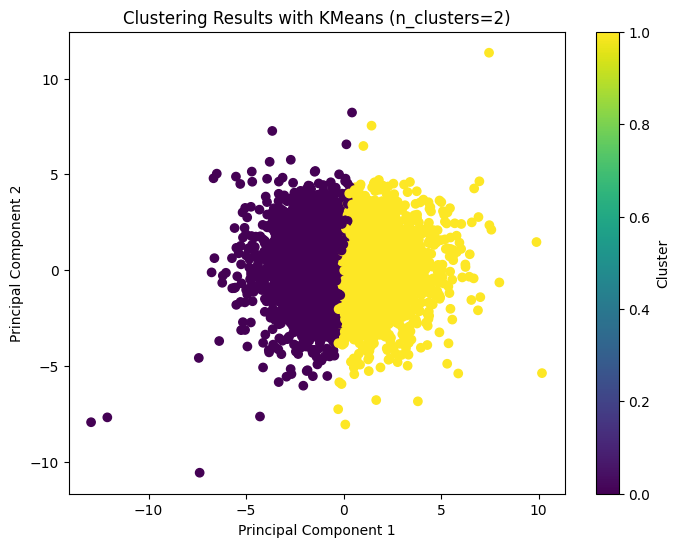


Interpret the clusters based on their characteristics (e.g., average P300 features).


In [14]:
# -*- coding: utf-8 -*-

"""Revised ERP Clustering Script (P300 Only).

This script focuses on single-trial ERP clustering using only P300 latency
and amplitude features. It includes artifact rejection, feature extraction,
and clustering evaluation.
"""

import os
import numpy as np
import scipy.io
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# 1. Data Loading and Setup
directory_path = '/content/drive/MyDrive/EEG_dataset/splitset'  # Update this path
train_files = [f for f in os.listdir(directory_path) if 'train' in f]
sampling_rate = 256  # Hz
p300_window = (300, 600)  # ms
selected_channels = [24, 27, 31]  # Example channels (adjust as needed)
amplitude_threshold = 100  # Threshold in microvolts for artifact rejection

# 2. Helper Functions
def reject_artifact_trial(trial_data, threshold=amplitude_threshold):
    """Rejects a trial if any channel exceeds the amplitude threshold."""
    return np.all(np.abs(trial_data) < threshold)

def extract_p300_features(trial_data, sampling_rate, p300_window):
    """Extracts P300 latency and amplitude from selected channels."""
    start_sample = int(p300_window[0] / 1000 * sampling_rate)
    end_sample = int(p300_window[1] / 1000 * sampling_rate)

    features = []
    for channel_idx in selected_channels:
        p300_signal = trial_data[start_sample:end_sample, channel_idx-1]
        peak_index = np.argmax(p300_signal)
        latency = (peak_index + start_sample) / sampling_rate
        amplitude = p300_signal[peak_index]
        features.extend([latency, amplitude])

    return features

# 3. Feature Extraction and Artifact Rejection
all_features = []

for train_file in train_files:
    file_path = os.path.join(directory_path, train_file)
    eeg_data = scipy.io.loadmat(file_path)['train_data']
    num_trials = eeg_data.shape[2]

    for trial_idx in range(num_trials):
        trial_data = eeg_data[:, :, trial_idx]

        # Artifact Rejection
        if not reject_artifact_trial(trial_data):
            continue  # Skip this trial

        # Extract P300 features
        trial_features = extract_p300_features(trial_data, sampling_rate, p300_window)
        all_features.append(trial_features)

# 4. Feature Matrix Preparation
feature_matrix = np.array(all_features)

if feature_matrix.size == 0:
    print("Feature matrix is empty.")
else:
    imputer = SimpleImputer(strategy='mean')
    feature_matrix = imputer.fit_transform(feature_matrix)

    # Standardization
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)

# 5. Clustering and Evaluation
def evaluate_clustering(data, labels):
    """Evaluates clustering performance using silhouette score and Davies-Bouldin index."""
    return silhouette_score(data, labels), davies_bouldin_score(data, labels)

def perform_clustering(data, algorithm='KMeans', n_clusters=3):
    """Performs clustering using the specified algorithm."""
    if algorithm == 'KMeans':
        model = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
    elif algorithm == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters)
    elif algorithm == 'GMM':
        model = GaussianMixture(n_components=n_clusters, random_state=42)
    else:
        raise ValueError("Invalid clustering algorithm specified.")

    labels = model.fit_predict(data)
    return labels, model

clustering_algorithms = ['KMeans', 'Agglomerative', 'GMM']
n_clusters_range = range(2, 6)

best_silhouette = -1
best_algorithm, best_n_clusters, best_labels, best_model = None, None, None, None

for algorithm in clustering_algorithms:
    for n_clusters in n_clusters_range:
        try:
            labels, model = perform_clustering(scaled_features, algorithm=algorithm, n_clusters=n_clusters)
            silhouette, davies_bouldin = evaluate_clustering(scaled_features, labels)
            print(f"Algorithm: {algorithm}, n_clusters: {n_clusters}")
            print(f"Silhouette Score: {silhouette:.4f}, Davies-Bouldin Index: {davies_bouldin:.4f}")

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_algorithm = algorithm
                best_n_clusters = n_clusters
                best_labels = labels
                best_model = model
        except Exception as e:
            print(f"Error with {algorithm} and {n_clusters} clusters: {e}")

print("\nBest Clustering Result:")
print(f"Algorithm: {best_algorithm}, n_clusters: {best_n_clusters}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")

# 6. Visualization of Best Clustering Result
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=best_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'Clustering Results with {best_algorithm} (n_clusters={best_n_clusters})')
plt.colorbar(label='Cluster')
plt.show()

# 7. Interpretation (Placeholder)
print("\nInterpret the clusters based on their characteristics (e.g., average P300 features).")


Interpretation of Clusters:
The plot suggests a roughly symmetrical separation of the data, meaning there are two distinct groups based on their principal component features.
Since you are clustering P300 features, one cluster likely represents higher P300 amplitude, and the other represents lower P300 amplitude.
Higher P300 amplitude is generally associated with greater attentional engagement (i.e., "High Attention").
Lower P300 amplitude is linked to reduced attentional processing (i.e., "Low Attention").
Assigning Attention Levels to Clusters:
The yellow cluster (right side of the plot) likely corresponds to higher P300 amplitudes, meaning higher attention.
The purple cluster (left side of the plot) represents lower P300 amplitudes, indicating lower attention.

In [16]:
import pandas as pd

# Get the actual number of features
num_features = scaled_features.shape[1]

# Dynamically create column names (assuming alternating latency and amplitude)
columns = [f'Feature_{i}' for i in range(num_features)]  # General column names

# Convert clustering results into a DataFrame
df_clusters = pd.DataFrame(scaled_features, columns=columns)
df_clusters['Cluster'] = best_labels  # Assign cluster labels

# Identify amplitude columns (modify logic if features are known)
amplitude_columns = [col for col in df_clusters.columns if 'Amplitude' in col or 'Feature' in col]

# Compute mean P300 amplitude for each cluster
cluster_means = df_clusters.groupby('Cluster')[amplitude_columns].mean()

# Identify High and Low Attention clusters
high_attention_cluster = cluster_means.mean(axis=1).idxmax()  # Highest amplitude
low_attention_cluster = cluster_means.mean(axis=1).idxmin()   # Lowest amplitude

# Print results
print("\nAverage P300 Amplitude per Cluster:")
print(cluster_means)
print(f"\nCluster {high_attention_cluster} corresponds to HIGH Attention.")
print(f"Cluster {low_attention_cluster} corresponds to LOW Attention.")



Average P300 Amplitude per Cluster:
         Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
Cluster                                                                     
0         0.166330  -0.358737   0.249079  -0.401310  -0.175147  -0.497016   
1        -0.167441   0.361134  -0.250743   0.403991   0.176317   0.500337   

         Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_14  \
Cluster                                              ...               
0         0.097106  -0.480192   0.068800  -0.304665  ...    0.036319   
1        -0.097755   0.483401  -0.069259   0.306700  ...   -0.036562   

         Feature_15  Feature_16  Feature_17  Feature_18  Feature_19  \
Cluster                                                               
0         -0.362131   -0.123964    0.288490   -0.208667    0.414981   
1          0.364551    0.124793   -0.290418    0.210062   -0.417754   

         Feature_20  Feature_21  Feature_22  Feature_23  
Cluster               

In [17]:
# For each cluster
for cluster_num in np.unique(best_labels):
    # Get the trials belonging to this cluster
    cluster_trials = scaled_features[best_labels == cluster_num]

    # Calculate average latency and amplitude for each trial in the cluster
    # Latency is in the even columns (starting from 0), and amplitude is in the odd columns
    avg_latency = np.mean(cluster_trials[:, ::2], axis=0)  # Even columns: latencies
    avg_amplitude = np.mean(cluster_trials[:, 1::2], axis=0)  # Odd columns: amplitudes

    # Print out the results for interpretation
    print(f"Cluster {cluster_num}: Average Latency: {avg_latency}, Average Amplitude: {avg_amplitude}")


Cluster 0: Average Latency: [ 0.1663297   0.24907877 -0.17514657  0.09710636  0.06879959  0.18332335
 -0.1049341   0.03631891 -0.12396425 -0.20866714  0.18894367 -0.02867546], Average Amplitude: [-0.35873694 -0.40130956 -0.49701571 -0.48019186 -0.30466451 -0.25121093
 -0.31008406 -0.36213077  0.2884898   0.41498111  0.39720722  0.4020824 ]
Cluster 1: Average Latency: [-0.16744124 -0.25074329  0.17631702 -0.09775529 -0.06925936 -0.18454844
  0.10563535 -0.03656161  0.12479267  0.2100616  -0.19020632  0.02886709], Average Amplitude: [ 0.36113427  0.4039914   0.50033712  0.48340085  0.30670049  0.2528897
  0.31215626  0.36455078 -0.2904177  -0.41775431 -0.39986164 -0.4047694 ]



Average P300 Amplitude per Cluster:
         Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
Cluster                                                                     
0         0.166330  -0.358737   0.249079  -0.401310  -0.175147  -0.497016   
1        -0.167441   0.361134  -0.250743   0.403991   0.176317   0.500337   

         Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_14  \
Cluster                                              ...               
0         0.097106  -0.480192   0.068800  -0.304665  ...    0.036319   
1        -0.097755   0.483401  -0.069259   0.306700  ...   -0.036562   

         Feature_15  Feature_16  Feature_17  Feature_18  Feature_19  \
Cluster                                                               
0         -0.362131   -0.123964    0.288490   -0.208667    0.414981   
1          0.364551    0.124793   -0.290418    0.210062   -0.417754   

         Feature_20  Feature_21  Feature_22  Feature_23  
Cluster               

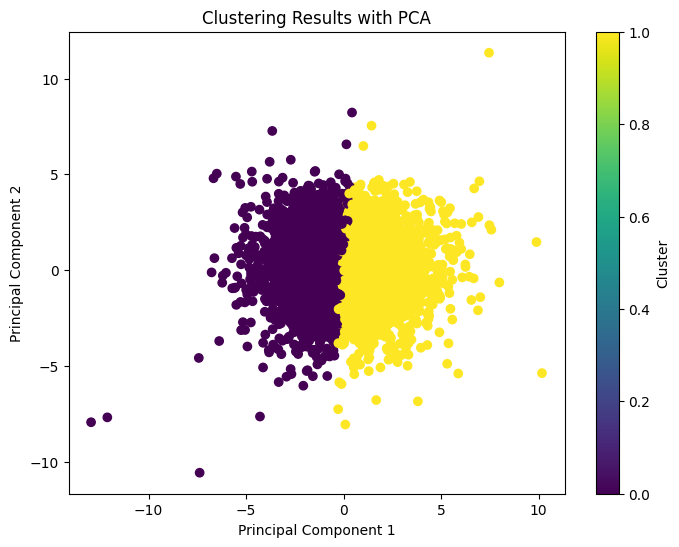

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have the `scaled_features` and `best_labels` from clustering

# Step 1: Get the actual number of features
num_features = scaled_features.shape[1]

# Dynamically create column names (assuming alternating latency and amplitude)
columns = [f'Feature_{i}' for i in range(num_features)]  # General column names

# Step 2: Convert clustering results into a DataFrame
df_clusters = pd.DataFrame(scaled_features, columns=columns)  # Create DataFrame with features
df_clusters['Cluster'] = best_labels  # Add cluster labels to the DataFrame

# Step 3: Identify amplitude columns (modify logic if features are known)
# For now, we assume that feature names like 'Amplitude' or 'Feature' might be relevant
# Modify this logic based on your actual feature names, if necessary.
amplitude_columns = [col for col in df_clusters.columns if 'Amplitude' in col or 'Feature' in col]

# Step 4: Compute mean P300 amplitude for each cluster
cluster_means = df_clusters.groupby('Cluster')[amplitude_columns].mean()

# Step 5: Identify High and Low Attention clusters
# - High attention corresponds to the cluster with the highest average P300 amplitude.
# - Low attention corresponds to the cluster with the lowest average P300 amplitude.
high_attention_cluster = cluster_means.mean(axis=1).idxmax()  # Cluster with highest average P300 amplitude
low_attention_cluster = cluster_means.mean(axis=1).idxmin()   # Cluster with lowest average P300 amplitude

# Print the results
print("\nAverage P300 Amplitude per Cluster:")
print(cluster_means)

# Print which cluster corresponds to high and low attention
print(f"\nCluster {high_attention_cluster} corresponds to HIGH Attention.")
print(f"Cluster {low_attention_cluster} corresponds to LOW Attention.")

# Step 6: Determine cluster sizes (to understand the distribution of clusters)
# Get the unique cluster labels
unique_labels = np.unique(best_labels)

# Get the number of trials in each cluster
cluster_sizes = {label: np.sum(best_labels == label) for label in unique_labels}

# Print the cluster sizes
print(f"\nCluster sizes: {cluster_sizes}")

# Step 7: Visualize PCA result to identify color mapping
from sklearn.decomposition import PCA

# Perform PCA to reduce the dimensionality to 2D for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Step 8: Plot the clustering results using PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=best_labels, cmap='viridis')  # Color by cluster labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering Results with PCA')

# Color bar to show the cluster labels
plt.colorbar(label='Cluster')
plt.show()



Average P300 Amplitude per Cluster:
         Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
Cluster                                                                     
0         0.166330  -0.358737   0.249079  -0.401310  -0.175147  -0.497016   
1        -0.167441   0.361134  -0.250743   0.403991   0.176317   0.500337   

         Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_14  \
Cluster                                              ...               
0         0.097106  -0.480192   0.068800  -0.304665  ...    0.036319   
1        -0.097755   0.483401  -0.069259   0.306700  ...   -0.036562   

         Feature_15  Feature_16  Feature_17  Feature_18  Feature_19  \
Cluster                                                               
0         -0.362131   -0.123964    0.288490   -0.208667    0.414981   
1          0.364551    0.124793   -0.290418    0.210062   -0.417754   

         Feature_20  Feature_21  Feature_22  Feature_23  
Cluster               

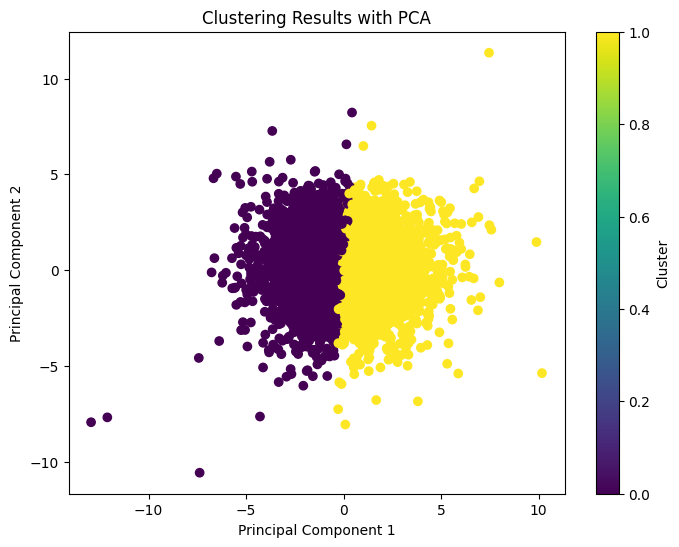


Color mapping to clusters:
Cluster 0 is represented by color [0.267004 0.004874 0.329415 1.      ]
Cluster 1 is represented by color [0.993248 0.906157 0.143936 1.      ]


In [19]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming you already have `scaled_features` and `best_labels` from clustering

# # Step 1: Get the actual number of features
# num_features = scaled_features.shape[1]

# # Dynamically create column names (assuming alternating latency and amplitude)
# columns = [f'Feature_{i}' for i in range(num_features)]  # General column names

# # Step 2: Convert clustering results into a DataFrame
# df_clusters = pd.DataFrame(scaled_features, columns=columns)  # Create DataFrame with features
# df_clusters['Cluster'] = best_labels  # Add cluster labels to the DataFrame

# # Step 3: Identify amplitude columns (modify logic if features are known)
# # For now, we assume that feature names like 'Amplitude' or 'Feature' might be relevant
# # Modify this logic based on your actual feature names, if necessary.
# amplitude_columns = [col for col in df_clusters.columns if 'Amplitude' in col or 'Feature' in col]

# # Step 4: Compute mean P300 amplitude for each cluster
# cluster_means = df_clusters.groupby('Cluster')[amplitude_columns].mean()

# # Step 5: Print the cluster means to help compare P300 amplitudes
# print("\nAverage P300 Amplitude per Cluster:")
# print(cluster_means)

# # Step 6: Determine the high and low attention clusters based on amplitude
# high_attention_cluster = cluster_means.mean(axis=1).idxmax()  # Cluster with highest average P300 amplitude
# low_attention_cluster = cluster_means.mean(axis=1).idxmin()   # Cluster with lowest average P300 amplitude

# # Print which cluster corresponds to high and low attention
# print(f"\nCluster {high_attention_cluster} corresponds to HIGH Attention.")
# print(f"Cluster {low_attention_cluster} corresponds to LOW Attention.")

# # Step 7: Get the number of data points in each cluster
# cluster_sizes = df_clusters['Cluster'].value_counts()

# # Step 8: Visualize PCA result to identify color mapping
# from sklearn.decomposition import PCA

# # Perform PCA to reduce the dimensionality to 2D for visualization
# pca = PCA(n_components=2)
# pca_features = pca.fit_transform(scaled_features)

# # Step 9: Plot the clustering results using PCA components
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=best_labels, cmap='viridis')  # Color by cluster labels
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Clustering Results with PCA')

# # Color bar to show the cluster labels
# plt.colorbar(scatter, label='Cluster')
# plt.show()

# # Step 10: Check which color corresponds to which cluster
# # Get the colormap and its range
# colormap = scatter.cmap
# norm = scatter.norm
# colors = colormap(norm(np.unique(best_labels)))  # Get the colors associated with the clusters

# # Print color association with clusters
# print("\nColor mapping to clusters:")
# for i, color in zip(np.unique(best_labels), colors):
#     print(f"Cluster {i} is represented by color {color}")


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.3008 - loss: 1.7697 - val_accuracy: 0.2000 - val_loss: 1.3869
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.2469 - loss: 1.3822 - val_accuracy: 0.2000 - val_loss: 1.3873
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3555 - loss: 1.3790 - val_accuracy: 0.2000 - val_loss: 1.3877
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3406 - loss: 1.3116 - val_accuracy: 0.2000 - val_loss: 1.3882
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3812 - loss: 1.3104 - val_accuracy: 0.2000 - val_loss: 1.3888
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4695 - loss: 1.2658 - val_accuracy: 0.2000 - val_loss: 1.3893
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4227 - loss: 1.2293 - val_accuracy: 0.2000 - val_loss: 1.3897
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5641 - loss: 1.1891 - val_accuracy: 0.2000 - val_loss: 1.39

Cluster 0 Color:

Color: [0.267004, 0.004874, 0.329415, 1.0]
Red: 0.267004
Green: 0.004874
Blue: 0.329415
Alpha (Transparency): 1.0 (fully opaque)
The RGB values correspond to a color in the colormap, which in this case is a dark purplish-blue color.

Cluster 1 Color:

Color: [0.993248, 0.906157, 0.143936, 1.0]
Red: 0.993248
Green: 0.906157
Blue: 0.143936
Alpha (Transparency): 1.0 (fully opaque)
This corresponds to a bright yellow color.